# Image Segmentation UNet from scratch.

Le but de ce projet? M'amuser et m'exercer 😄! 

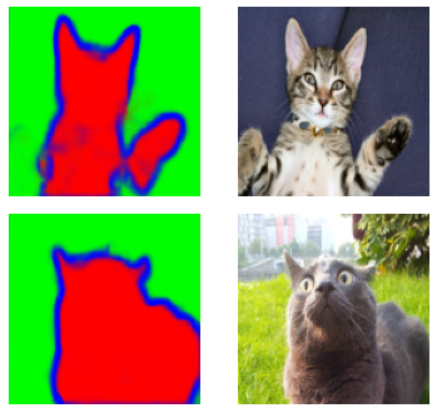

## Let's start!! ✅

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
def normalize(input_image, input_mask):
  '''
  normalizes the input image pixel values to be from [0,1].
  subtracts 1 from the mask labels to have a range from [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image_test(datapoint):
  '''resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

train = dataset["train"].map(load_image_test)
test = dataset["test"].map(load_image_test)


In [4]:
train = train.batch(64).prefetch(1)
test = test.batch(64).prefetch(1)

## UNet ⚡

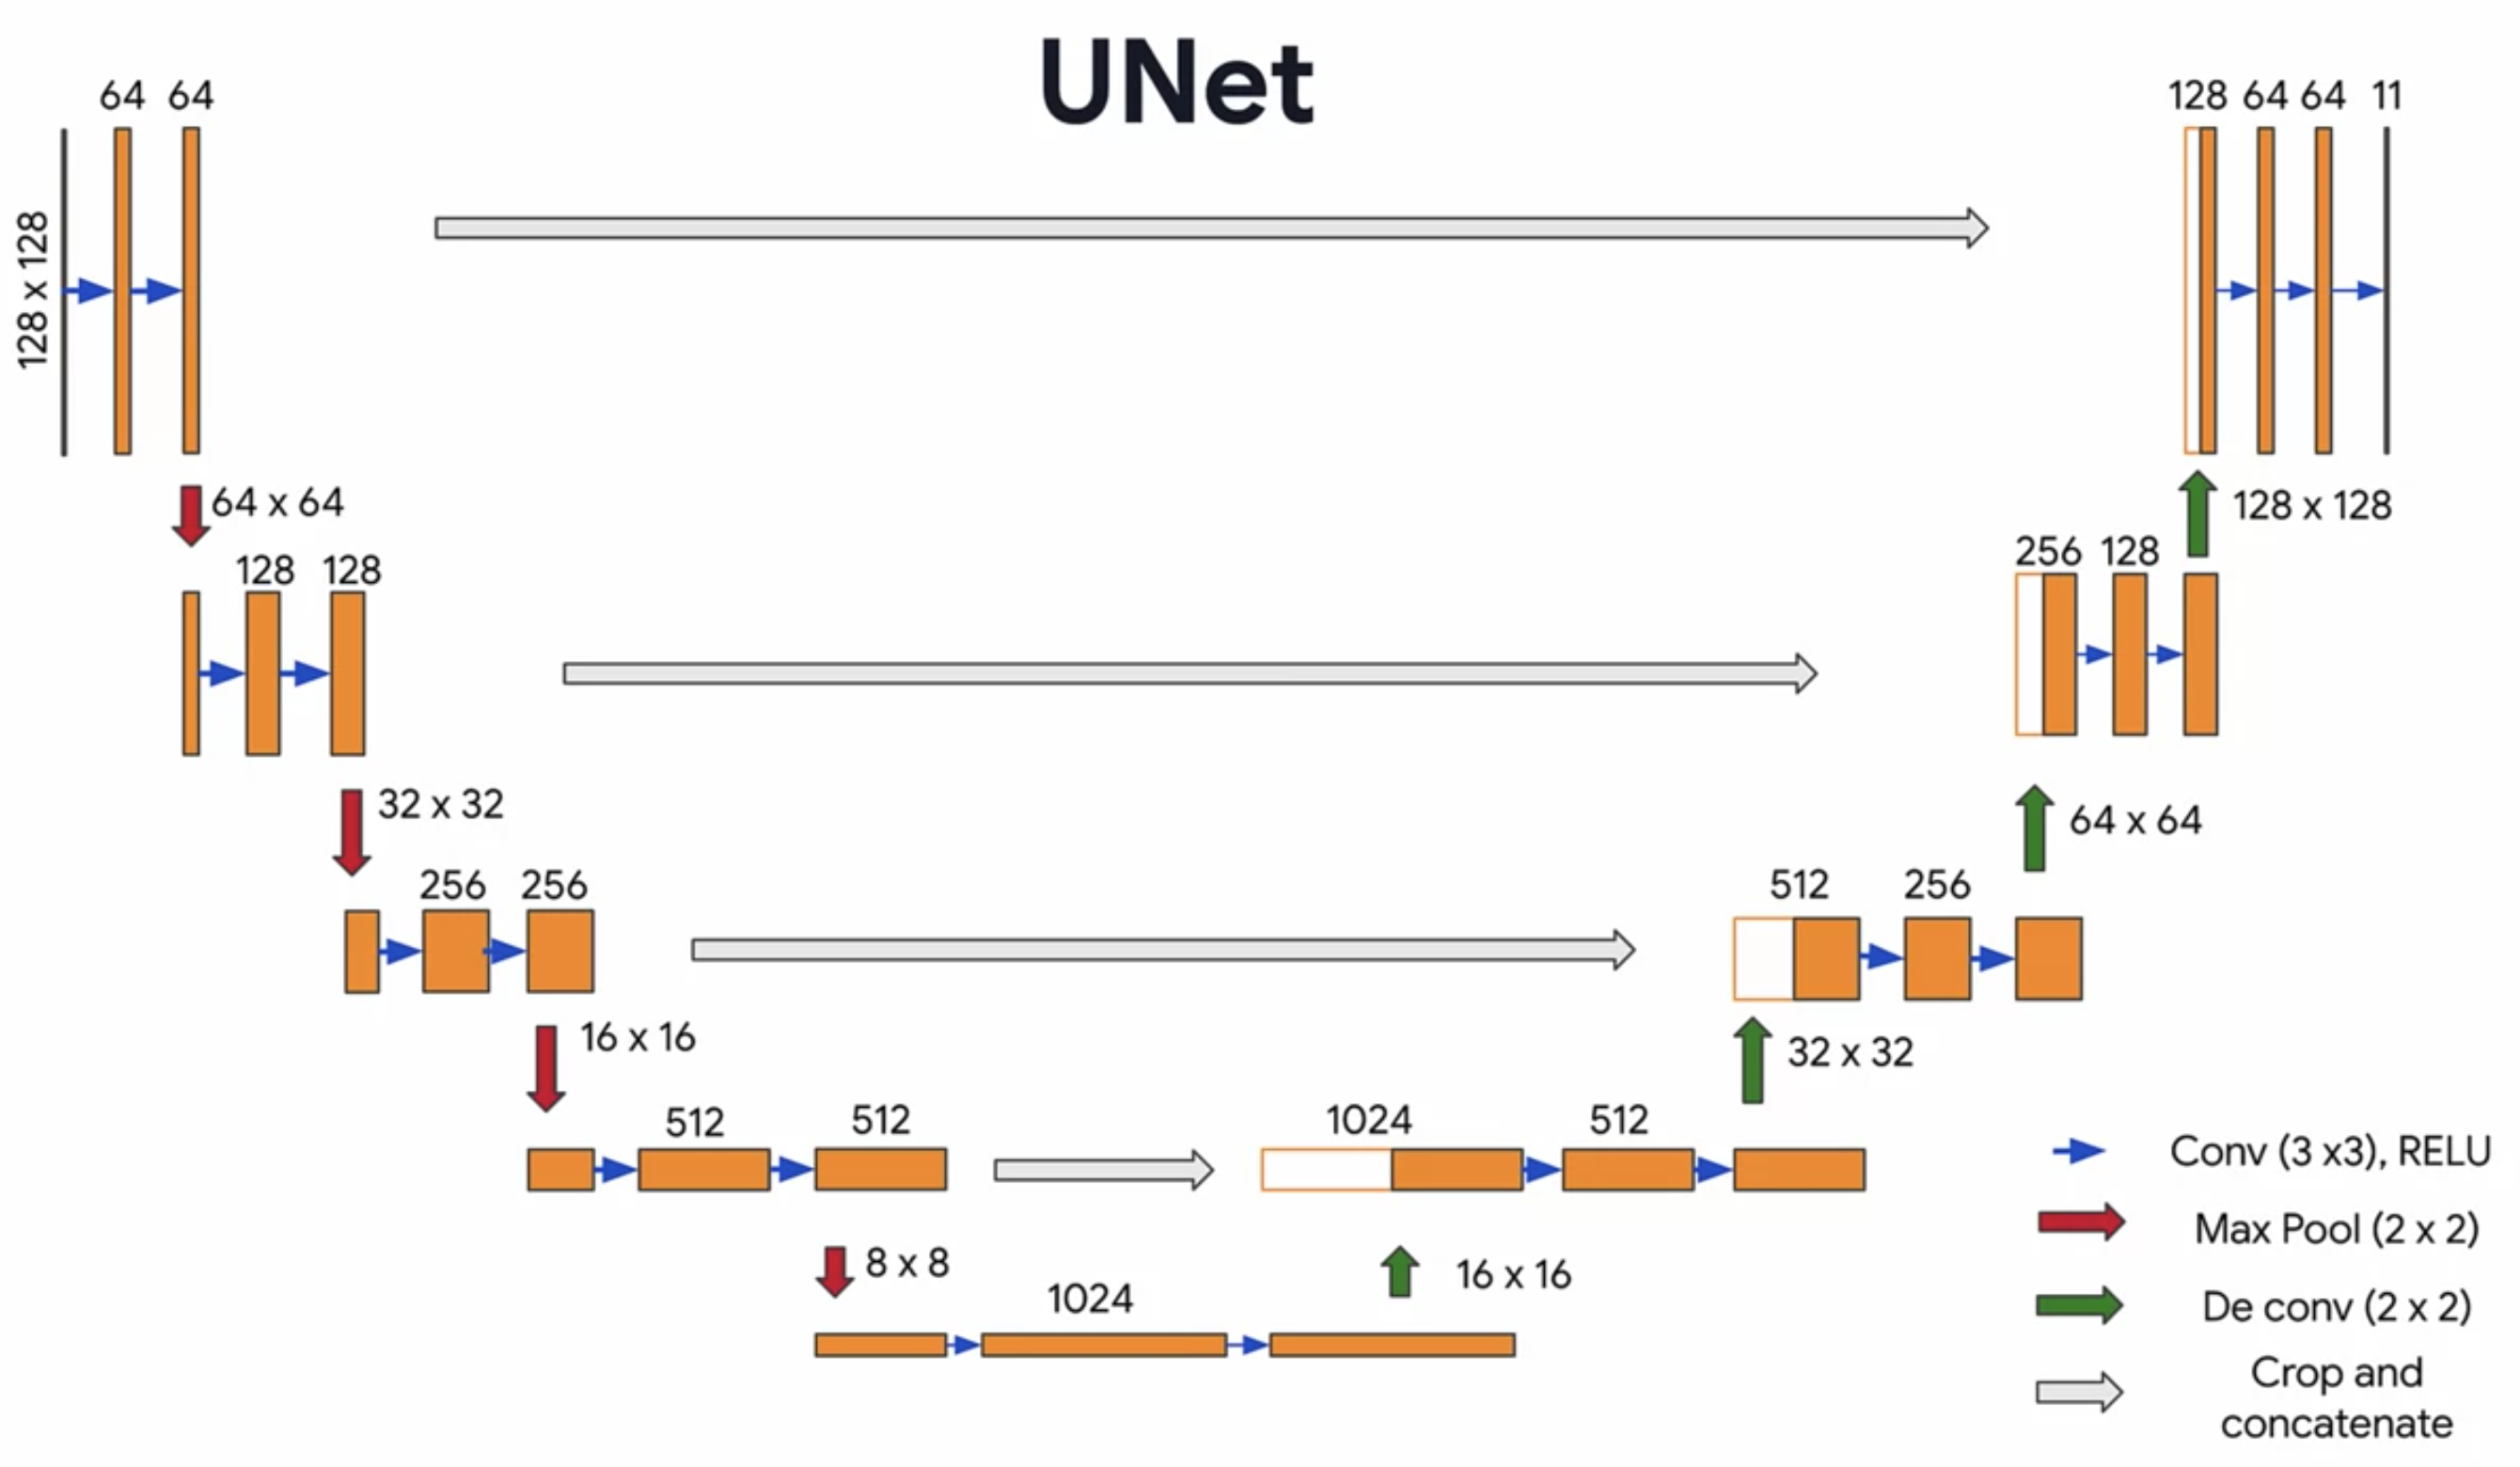

In [5]:
class Forward(tf.keras.layers.Layer):
  def __init__(self, number_filters):

    super(Forward, self).__init__()

    self.c1 = tf.keras.layers.Conv2D(number_filters, kernel_size=(3, 3), activation="relu", padding="same")
    self.c2 = tf.keras.layers.Conv2D(number_filters, kernel_size=(3, 3), activation="relu", padding="same")
    self.maxpool = tf.keras.layers.MaxPooling2D((2,2))
  
  def call(self, x):
    x = self.c1(x)
    out = self.c2(x)
    x = self.maxpool(out)

    return x, out

In [6]:
class Upward(tf.keras.layers.Layer):
  def __init__(self, number_filters):

    super(Upward, self).__init__()

    self.concat = tf.keras.layers.Concatenate(axis=-1)
    self.c1 = tf.keras.layers.Conv2D(number_filters, kernel_size=(3, 3), activation="relu", padding="same")
    self.c2 = tf.keras.layers.Conv2D(number_filters, kernel_size=(3, 3), activation="relu", padding="same")
    self.Up = tf.keras.layers.Conv2DTranspose(number_filters / 2, kernel_size=(3, 3), strides = (2,2), padding="same")
  
  def call(self, x, res):
    x = self.concat([x, res])
    x = self.c1(x)
    x = self.c2(x)
    x = self.Up(x)

    return x

In [7]:
class FinalUpward(tf.keras.layers.Layer):
  def __init__(self, number_filters):

    super(FinalUpward, self).__init__()

    self.concat = tf.keras.layers.Concatenate(axis=-1)
    self.c1 = tf.keras.layers.Conv2D(number_filters, kernel_size=(3, 3), activation="relu", padding="same")
    self.c2 = tf.keras.layers.Conv2D(number_filters, kernel_size=(3, 3), activation="relu", padding="same")
    self.Up = tf.keras.layers.Conv2DTranspose(3, 7, padding="same", activation="softmax")
  
  def call(self, x, res):
    x = self.concat([x, res])
    x = self.c1(x)
    x = self.c2(x)
    x = self.Up(x)

    return x

In [8]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__()

    self.u1 = Upward(512)
    self.u2 = Upward(256)
    self.u3 = Upward(128)
    self.u4 = FinalUpward(64)
  
  def call(self, x, input_res):
    x1, x2, x3, x4 = input_res

    x = self.u1(x, x4)
    x = self.u2(x, x3)
    x = self.u3(x, x2)
    x = self.u4(x, x1)
    # print("shape", x.shape)
    return x

In [9]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self):
    super(Encoder, self).__init__()

    self.f1 = Forward(64)
    self.f2 = Forward(128)
    self.f3 = Forward(256)
    self.f4 = Forward(512)

  def call(self, x):
    x1, o1 = self.f1(x)
    x2, o2 = self.f2(x1)
    x3, o3 = self.f3(x2)
    x4, o4 = self.f4(x3)

    return x4, o1, o2, o3, o4

In [10]:
class BottleNeck(tf.keras.layers.Layer):
  def __init__(self):
    super(BottleNeck, self).__init__()
    self.c1 = tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), activation="relu", padding="same")
    self.c2 = tf.keras.layers.Conv2DTranspose(512, kernel_size=(3, 3), strides = (2,2), padding="same")
  
  def call(self, x):
    x = self.c1(x)
    x = self.c2(x)

    return x

In [11]:
inp = tf.keras.layers.Input(shape=(128,128,3))
x4, o1, o2, o3, o4 = Encoder()(inp)
b = BottleNeck()(x4)
c = Decoder()(b, [o1, o2, o3, o4])
model = tf.keras.models.Model(inp, c)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Encoder)              ((None, 8, 8, 512),  4685376     ['input_1[0][0]']                
                                 (None, 128, 128, 6                                               
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                            

In [21]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

train_acc = tf.keras.metrics.Mean()
train_loss = tf.keras.metrics.Mean()

acc = tf.keras.metrics.SparseCategoricalAccuracy()

optimizer = tf.keras.optimizers.Adam()

def TRAIN(x, y):
  with tf.GradientTape() as tape:
    pred = model(x)
    tape.watch(pred)
    loss = loss_obj(y, pred)
  
  grad = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grad, model.trainable_variables))

  train_acc(acc(y, pred))
  train_loss(loss)

epochs = 20

for epoch in range(epochs):
  train_acc.reset_states()
  train_loss.reset_states()

  for (step, (x, y)) in enumerate(train):
    TRAIN(x, y)

  print(f"Epoch {epoch + 1} Loss {train_loss.result()} Acc {train_acc.result()}")

Epoch 1 Loss 0.34714609384536743 Acc 0.8462780714035034
Epoch 2 Loss 0.2130269855260849 Acc 0.8847889304161072
Epoch 3 Loss 0.1964680552482605 Acc 0.899105429649353
Epoch 4 Loss 0.18694786727428436 Acc 0.9063042402267456
Epoch 5 Loss 0.1823975145816803 Acc 0.9107110500335693
Epoch 6 Loss 0.18454661965370178 Acc 0.913625180721283
Epoch 7 Loss 0.19872023165225983 Acc 0.9152736067771912
Epoch 8 Loss 0.1914559304714203 Acc 0.9162574410438538
Epoch 9 Loss 0.192398801445961 Acc 0.917116641998291
Epoch 10 Loss 0.19682282209396362 Acc 0.9177592992782593
Epoch 11 Loss 0.19245733320713043 Acc 0.9182429313659668
Epoch 12 Loss 0.18860283493995667 Acc 0.9187197685241699
Epoch 13 Loss 0.18814606964588165 Acc 0.9191615581512451
Epoch 14 Loss 0.1852126121520996 Acc 0.9196382164955139
Epoch 15 Loss 0.18038806319236755 Acc 0.9202027320861816
Epoch 16 Loss 0.18184562027454376 Acc 0.9206496477127075
Epoch 17 Loss 0.17908886075019836 Acc 0.9210933446884155
Epoch 18 Loss 0.18198958039283752 Acc 0.9214422106

## Tests ✨

In [14]:
!wget -q https://content.thriveglobal.in/wp-content/uploads/sites/3/2020/08/anoir-chafik-2_3c4dIFYFU-unsplash.jpg
!wget -q https://i.pinimg.com/originals/93/76/59/93765909e6967fce3cba21445580a6b4.jpg
!wget -q https://live.staticflickr.com/4107/5053571198_f7d10de1ca_n.jpg
!wget -q https://i.pinimg.com/originals/85/90/14/8590141764dcf91f8d1e206b2def8501.jpg
!wget -q https://images2.fanpop.com/image/photos/13400000/Cat-cats-13494211-1600-1067.jpg
!wget -q https://eatliver.b-cdn.net/wp-content/uploads/2014/08/shocked-cat.jpg

In [45]:
def image_preproc(link):
  img = tf.keras.preprocessing.image.load_img(link)
  img = img.resize((128,128))
  img = np.float32(img) / 255.
  img = np.expand_dims(img, axis=0)
  return img

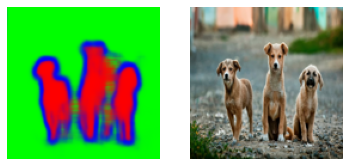

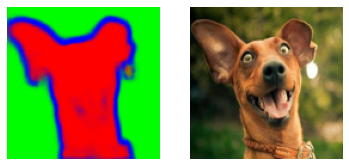

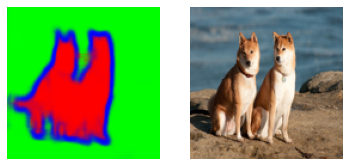

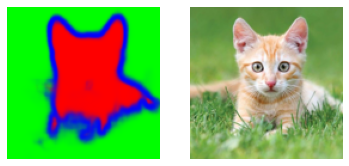

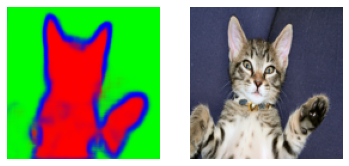

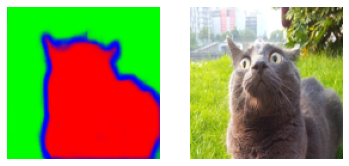

In [46]:
dog1 = image_preproc("/content/anoir-chafik-2_3c4dIFYFU-unsplash.jpg")
dog2 = image_preproc("/content/93765909e6967fce3cba21445580a6b4.jpg")
dog3 = image_preproc("/content/5053571198_f7d10de1ca_n.jpg")

cat1 = image_preproc("/content/8590141764dcf91f8d1e206b2def8501.jpg")
cat2 = image_preproc("/content/Cat-cats-13494211-1600-1067.jpg")
cat3 = image_preproc("/content/shocked-cat.jpg")

for img in [dog1, dog2, dog3, cat1, cat2, cat3]:
  pred = model.predict(img)
  pred = np.squeeze(pred, axis=0)

  plt.subplot(1,2,1)
  plt.imshow(pred)
  plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(img, axis=0))
  plt.axis("off")
  plt.show()